Simple training without any fine tuning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# datasets

categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

print(train_data.info())

merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

print(merged_data)
print("Shape after dropping missing values:", merged_data.shape)

# missing values
merged_data.isnull().sum()

merged_data_clean = merged_data.dropna()

# merged_data_clean.isnull().sum()
print("Shape after dropping missing values:", merged_data_clean.shape)


categorical_cols = merged_data_clean.select_dtypes(include='object').columns
print(categorical_cols)

# target variables
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]

# dropping participant_id and target variables
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

X_scaled = StandardScaler().fit_transform(X)

# train - test split data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=108)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report


# --- Define models ---
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=108)),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    'LightGBM': MultiOutputClassifier(LGBMClassifier(random_state=108))
}

# --- Evaluate each model ---
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    adhd_acc = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])
    sex_acc = accuracy_score(y_test['Sex_F'], y_pred[:, 1])
    
    results.append({
        'Model': name,
        'ADHD_Accuracy': adhd_acc,
        'Sex_Accuracy': sex_acc,
        'Average_Accuracy': np.mean([adhd_acc, sex_acc])
    })

    print(f"{name} ADHD Accuracy: {adhd_acc:.4f}, Sex Accuracy: {sex_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ADHD_Outcome', 'Sex_F'], zero_division=0))

# --- Show summary ---
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None
     participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0      00aIpNTbG5uh                     2019                       4   
1      00fV0OyyoLfw                     2017                       1   
2      04X1eiS79T4B                     2017                       1   
3      05ocQutkURd6                     2018                       1   
4      06YUNBA9ZRLq                     2018                       1   
...             ...                      ...                     ...   
1208   zwjJWCRzKhDz                     2019                       4   
1209   zwXD5v17Rx01                     20

PCA

Training datasets loaded successfully.
Shape before dropping missing values: (1213, 19930)
Shape after dropping missing values: (619, 19930)
Training feature columns saved.
Standardization applied and scaler saved.
PCA selected 565 components to retain 98.0% variance.
PCA applied and transformer saved.


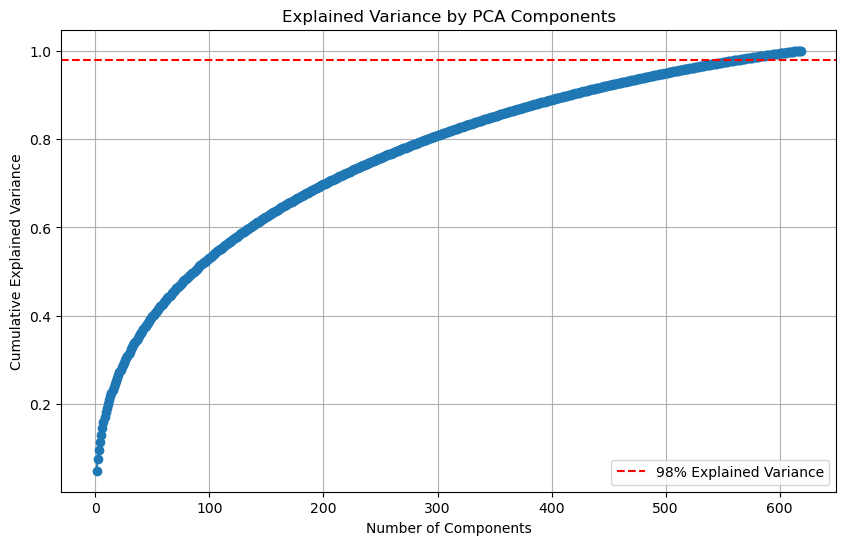


Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 166, number of negative: 329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93412
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 565
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335354 -> initscore=-0.684070
[LightGBM] [Info] Start training from score -0.684070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

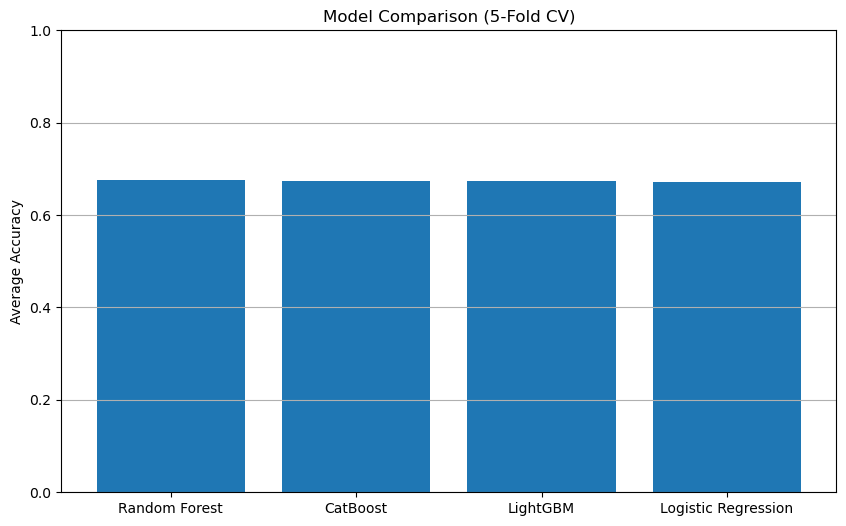


Best model selected: Random Forest
Best model retrained and saved successfully.
Test datasets loaded successfully.
Test data merged and cleaned.
Test features aligned successfully.
Scaling applied successfully.
PCA transformation applied successfully.
Prediction completed successfully.

Predictions saved to 'test_predictions.csv'.
  participant_id  Sex_F_predicted  ADHD_Outcome_predicted
0   Cfwaf5FX7jWK                0                       1
2   ULliyEXjy4OV                0                       1
3   LZfeAb1xMtql                0                       1
4   EnFOUv0YK1RG                0                       1
6   PRKZcnOgqcuk                0                       1


In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# =========================
# --- Load TRAIN datasets ---
# =========================
try:
    categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
    quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
    connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
    train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")
    print("Training datasets loaded successfully.")
except Exception as e:
    print("Error loading training datasets.")
    print(e)
    raise

# Merge datasets
try:
    merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
    merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
    merged_data = merged_data.merge(train_data, on='participant_id', how='inner')
    print("Shape before dropping missing values:", merged_data.shape)
except Exception as e:
    print("Error during merging datasets.")
    print(e)
    raise

# Drop missing values
merged_data_clean = merged_data.dropna()
print("Shape after dropping missing values:", merged_data_clean.shape)

# Feature/target split
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

# Save columns for future
joblib.dump(X.columns.tolist(), "train_columns.joblib")
print("Training feature columns saved.")

# =========================
# --- Standardization and PCA ---
# =========================
try:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, "scaler.joblib")
    print("Standardization applied and scaler saved.")
except Exception as e:
    print("Error during standardization.")
    print(e)
    raise

# PCA for 98% variance
try:
    target_variance = 0.98
    pca_full = PCA(random_state=108)
    X_pca_full = pca_full.fit_transform(X_scaled)
    explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(explained_variance_ratio >= target_variance) + 1
    print(f"PCA selected {n_components} components to retain {target_variance*100:.1f}% variance.")

    pca_final = PCA(n_components=n_components, random_state=108)
    X_pca = pca_final.fit_transform(X_scaled)
    joblib.dump(pca_final, "pca_transformer.joblib")
    print("PCA applied and transformer saved.")

    # Plot variance
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
    plt.axhline(y=target_variance, color='r', linestyle='--', label=f'{int(target_variance*100)}% Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid()
    plt.legend()
    plt.show()
except Exception as e:
    print("Error during PCA.")
    print(e)
    raise

# =========================
# --- Model Training and Cross-Validation ---
# =========================
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=108),
    'CatBoost': CatBoostClassifier(iterations=100, verbose=0, random_state=108)
}

def multioutput_accuracy_per_target(y_true, y_pred):
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])
    avg_acc = np.mean([adhd_acc, sex_acc])
    return adhd_acc, sex_acc, avg_acc

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=108)

for name, base_model in models.items():
    print(f"\nEvaluating {name}...")

    model = MultiOutputClassifier(base_model)
    adhd_accuracies, sex_accuracies = [], []

    for train_idx, test_idx in kf.split(X_pca):
        X_train_cv, X_test_cv = X_pca[train_idx], X_pca[test_idx]
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)

    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])

    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })

# Show model performance
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

# Plot
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold CV)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# =========================
# --- Final Model Training ---
# =========================
try:
    best_model_name = results_df.iloc[0]['Model']
    print(f"\nBest model selected: {best_model_name}")

    base_model_mapping = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'LightGBM': LGBMClassifier(random_state=108),
        'CatBoost': CatBoostClassifier(iterations=100, verbose=0, random_state=108)
    }

    final_model = MultiOutputClassifier(base_model_mapping[best_model_name])
    final_model.fit(X_pca, y)
    joblib.dump(final_model, "random_forest_multioutput_model.joblib")
    print("Best model retrained and saved successfully.")
except Exception as e:
    print("Error during final model training.")
    print(e)
    raise

# =========================
# --- TEST DATA Prediction ---
# =========================
try:
    categorical_test = pd.read_excel("TEST/TEST_CATEGORICAL.xlsx")
    quantitative_test = pd.read_excel("TEST/TEST_QUANTITATIVE_METADATA.xlsx")
    connectome_test = pd.read_csv("TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    print("Test datasets loaded successfully.")
except Exception as e:
    print("Error loading test datasets.")
    print(e)
    raise

# Merge and clean test
try:
    test_data_clean = categorical_test.merge(quantitative_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.merge(connectome_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.dropna()
    print("Test data merged and cleaned.")
except Exception as e:
    print("Error during test data merging.")
    print(e)
    raise

# Preprocess test
try:
    participant_ids = test_data_clean['participant_id']
    X_test = test_data_clean.drop(['participant_id'], axis=1)

    train_columns = joblib.load("train_columns.joblib")
    X_test = X_test[train_columns]
    print("Test features aligned successfully.")
except Exception as e:
    print("\nError: Test features do not match training features.")
    print(e)
    raise

try:
    scaler = joblib.load("scaler.joblib")
    X_test_scaled = scaler.transform(X_test)
    print("Scaling applied successfully.")
except Exception as e:
    print("\nError during scaling of test set.")
    print(e)
    raise

try:
    pca_final = joblib.load("pca_transformer.joblib")
    X_test_pca = pca_final.transform(X_test_scaled)
    print("PCA transformation applied successfully.")
except Exception as e:
    print("\nError during PCA transformation of test set.")
    print(e)
    raise

# Predict
try:
    best_model = joblib.load("random_forest_multioutput_model.joblib")
    y_pred_test = best_model.predict(X_test_pca)
    print("Prediction completed successfully.")
except Exception as e:
    print("\nError during prediction.")
    print(e)
    raise

# Save submission
try:
    submission_df = pd.DataFrame({
        'participant_id': participant_ids,
        'Sex_F_predicted': y_pred_test[:, 0],
        'ADHD_Outcome_predicted': y_pred_test[:, 1]
    })
    submission_df.to_csv("test_predictions.csv", index=False)
    print("\nPredictions saved to 'test_predictions.csv'.")
    print(submission_df.head())
except Exception as e:
    print("\nError during saving predictions.")
    print(e)
    raise


Model feature selection

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# datasets

categorical_data = pd.read_excel("train_new/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_data = pd.read_excel("train_new/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_data = pd.read_csv("train_new/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
train_data = pd.read_excel("train_new/TRAINING_SOLUTIONS.xlsx")

print(train_data.info())

merged_data = categorical_data.merge(quantitative_data, on='participant_id', how='inner')
merged_data = merged_data.merge(connectome_data, on='participant_id', how='inner')
merged_data = merged_data.merge(train_data, on='participant_id', how='inner')

print(merged_data)
print("Shape after dropping missing values:", merged_data.shape)

# missing values
merged_data.isnull().sum()

merged_data_clean = merged_data.dropna()

# merged_data_clean.isnull().sum()
print("Shape after dropping missing values:", merged_data_clean.shape)


categorical_cols = merged_data_clean.select_dtypes(include='object').columns
print(categorical_cols)

# target variables
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]

# dropping participant_id and target variables
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

X_scaled = StandardScaler().fit_transform(X)

# train - test split data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=108)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report


# --- Define models ---
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=108)),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    'LightGBM': MultiOutputClassifier(LGBMClassifier(random_state=108))
}

# --- Evaluate each model ---
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    adhd_acc = accuracy_score(y_test['ADHD_Outcome'], y_pred[:, 0])
    sex_acc = accuracy_score(y_test['Sex_F'], y_pred[:, 1])
    
    results.append({
        'Model': name,
        'ADHD_Accuracy': adhd_acc,
        'Sex_Accuracy': sex_acc,
        'Average_Accuracy': np.mean([adhd_acc, sex_acc])
    })

    print(f"{name} ADHD Accuracy: {adhd_acc:.4f}, Sex Accuracy: {sex_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['ADHD_Outcome', 'Sex_F'], zero_division=0))

# --- Show summary ---
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   participant_id  1213 non-null   object
 1   ADHD_Outcome    1213 non-null   int64 
 2   Sex_F           1213 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 28.6+ KB
None
     participant_id  Basic_Demos_Enroll_Year  Basic_Demos_Study_Site  \
0      00aIpNTbG5uh                     2019                       4   
1      00fV0OyyoLfw                     2017                       1   
2      04X1eiS79T4B                     2017                       1   
3      05ocQutkURd6                     2018                       1   
4      06YUNBA9ZRLq                     2018                       1   
...             ...                      ...                     ...   
1208   zwjJWCRzKhDz                     2019                       4   
1209   zwXD5v17Rx01                     20

Training feature columns saved.
Standardization applied and scaler saved.


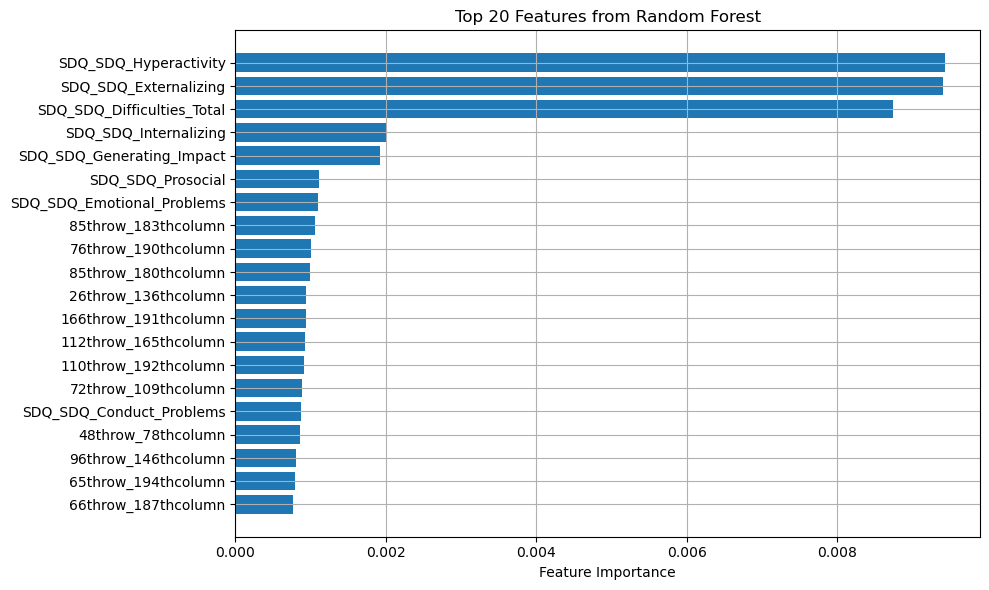

Selected 3 features with importance >= 0.004

Evaluating Random Forest...

Evaluating Logistic Regression...

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 166, number of negative: 329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335354 -> initscore=-0.684070
[LightGBM] [Info] Start training from score -0.684070
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

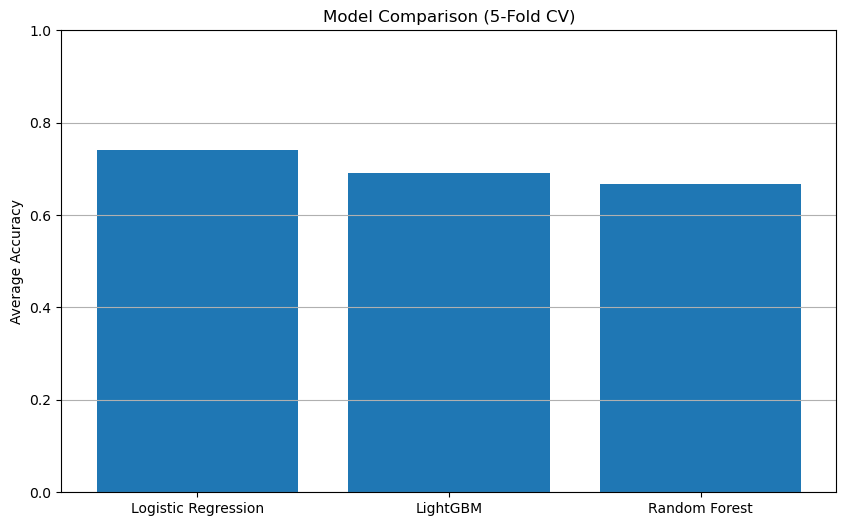


Best model selected: Logistic Regression
Best model retrained and saved successfully.
Test datasets loaded successfully.
Test data merged and cleaned.
Test features aligned successfully.
Scaling applied successfully.
Manually selected test features using saved importance list.
Prediction completed successfully.

Predictions saved to 'test_predictions_final.csv'.
  participant_id  Sex_F_predicted  ADHD_Outcome_predicted
0   Cfwaf5FX7jWK                0                       1
2   ULliyEXjy4OV                0                       0
3   LZfeAb1xMtql                0                       1
4   EnFOUv0YK1RG                0                       1
6   PRKZcnOgqcuk                0                       0


In [4]:
import matplotlib.pyplot as plt
import joblib

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Feature/target split
y = merged_data_clean[['Sex_F', 'ADHD_Outcome']]
X = merged_data_clean.drop(['participant_id', 'Sex_F', 'ADHD_Outcome'], axis=1)

# Save columns for future
joblib.dump(X.columns.tolist(), "train_columns.joblib")
print("Training feature columns saved.")

# =========================
# --- Standardization ---
# =========================
try:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, "scaler.joblib")
    print("Standardization applied and scaler saved.")
except Exception as e:
    print("Error during standardization.")
    print(e)
    raise

# =========================
# --- Model-Based Feature Selection ---
# =========================
try:
    rf = RandomForestClassifier(n_estimators=200,class_weight='balanced', random_state=108)
    rf.fit(X_scaled, y['ADHD_Outcome'])

    # Get feature importances
    importances = rf.feature_importances_
    feature_names = np.array(X.columns)

    # Plot top 20 features
    top_n = 20
    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), feature_names[indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Features from Random Forest')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # --- Manual thresholding ---
    importance_threshold = 0.004
    selected_mask = importances >= importance_threshold

    selected_features = feature_names[selected_mask]
    print(f"Selected {len(selected_features)} features with importance >= {importance_threshold}")

    # Filter X to selected features
    X_selected = X_scaled[:, selected_mask]

    # Save for future test-time use
    joblib.dump(selected_features.tolist(), "selected_feature_names.joblib")
    joblib.dump(rf, "feature_selector_model.joblib")

except Exception as e:
    print("Error during feature selection and plotting.")
    print(e)
    raise

# =========================
# --- Model Training and Cross-Validation ---
# =========================
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=108),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=108)
}

def multioutput_accuracy_per_target(y_true, y_pred):
    adhd_acc = accuracy_score(y_true[:, 1], y_pred[:, 1])
    sex_acc = accuracy_score(y_true[:, 0], y_pred[:, 0])
    avg_acc = np.mean([adhd_acc, sex_acc])
    return adhd_acc, sex_acc, avg_acc

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=108)

for name, base_model in models.items():
    print(f"\nEvaluating {name}...")

    model = MultiOutputClassifier(base_model)
    adhd_accuracies, sex_accuracies = [], []

    for train_idx, test_idx in kf.split(X_selected):
        X_train_cv, X_test_cv = X_selected[train_idx], X_selected[test_idx]
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        adhd_acc, sex_acc, _ = multioutput_accuracy_per_target(y_test_cv, y_pred_cv)
        adhd_accuracies.append(adhd_acc)
        sex_accuracies.append(sex_acc)

    mean_adhd_acc = np.mean(adhd_accuracies)
    mean_sex_acc = np.mean(sex_accuracies)
    avg_acc = np.mean([mean_adhd_acc, mean_sex_acc])

    results.append({
        'Model': name,
        'ADHD_Accuracy': mean_adhd_acc,
        'Sex_Accuracy': mean_sex_acc,
        'Average_Accuracy': avg_acc
    })

# Show model performance
results_df = pd.DataFrame(results).sort_values(by='Average_Accuracy', ascending=False)
print("\nModel Comparison Summary:")
print(results_df)

# Plot
plt.figure(figsize=(10,6))
plt.bar(results_df['Model'], results_df['Average_Accuracy'])
plt.ylabel('Average Accuracy')
plt.title('Model Comparison (5-Fold CV)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# =========================
# --- Final Model Training ---
# =========================
try:
    best_model_name = results_df.iloc[0]['Model']
    print(f"\nBest model selected: {best_model_name}")

    base_model_mapping = {
        'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=108),
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'LightGBM': LGBMClassifier(random_state=108)
    }

    final_model = MultiOutputClassifier(base_model_mapping[best_model_name])
    final_model.fit(X_selected, y)
    joblib.dump(final_model, "random_forest_multioutput_model.joblib")
    print("Best model retrained and saved successfully.")
except Exception as e:
    print("Error during final model training.")
    print(e)
    raise

# =========================
# --- TEST DATA Prediction ---
# =========================
try:
    categorical_test = pd.read_excel("widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")
    quantitative_test = pd.read_excel("widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
    connectome_test = pd.read_csv("widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    print("Test datasets loaded successfully.")
except Exception as e:
    print("Error loading test datasets.")
    print(e)
    raise

try:
    test_data_clean = categorical_test.merge(quantitative_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.merge(connectome_test, on='participant_id', how='inner')
    test_data_clean = test_data_clean.dropna()
    print("Test data merged and cleaned.")
except Exception as e:
    print("Error during test data merging.")
    print(e)
    raise

# Preprocess test
try:
    participant_ids = test_data_clean['participant_id']
    X_test = test_data_clean.drop(['participant_id'], axis=1)

    train_columns = joblib.load("train_columns.joblib")
    X_test = X_test[train_columns]
    print("Test features aligned successfully.")
except Exception as e:
    print("\nError: Test features do not match training features.")
    print(e)
    raise

try:
    scaler = joblib.load("scaler.joblib")
    X_test_scaled = scaler.transform(X_test)
    print("Scaling applied successfully.")
except Exception as e:
    print("\nError during scaling of test set.")
    print(e)
    raise

# Apply feature selector
# Manually select based on saved feature names
try:
    selected_feature_names = joblib.load("selected_feature_names.joblib")
    X_test_filtered = pd.DataFrame(X_test_scaled, columns=train_columns)[selected_feature_names]
    X_test_selected = X_test_filtered.values
    print("Manually selected test features using saved importance list.")
except Exception as e:
    print("\nError during manual test feature selection.")
    print(e)
    raise

# Predict
try:
    best_model = joblib.load("random_forest_multioutput_model.joblib")
    y_pred_test = best_model.predict(X_test_selected)
    print("Prediction completed successfully.")
except Exception as e:
    print("\nError during prediction.")
    print(e)
    raise

# Save submission
try:
    submission_df = pd.DataFrame({
        'participant_id': participant_ids,
        'Sex_F_predicted': y_pred_test[:, 0],
        'ADHD_Outcome_predicted': y_pred_test[:, 1]
    })
    submission_df.to_csv("test_predictions_final.csv", index=False)
    print("\nPredictions saved to 'test_predictions_final.csv'.")
    print(submission_df.head())
except Exception as e:
    print("\nError during saving predictions.")
    print(e)
    raise

In [ ]:
# Train selector with higher n_estimators
rf = RandomForestClassifier(n_estimators=200, random_state=108)
rf.fit(X_scaled, y['ADHD_Outcome'])

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort and plot top N features
top_n = 20
indices = np.argsort(importances)[-top_n:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Features from Random Forest')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("test_predictions_final.csv")

print("Sex_F prediction counts:")
print(df["Sex_F_predicted"].value_counts())

print("\nADHD_Outcome prediction counts:")
print(df["ADHD_Outcome_predicted"].value_counts())


In [ ]:
print("Sex_F distribution:")
print(y["Sex_F"].value_counts(normalize=True))

print("ADHD_Outcome distribution:")
print(y["ADHD_Outcome"].value_counts(normalize=True))


Prediction vs Actual Distribution

Variable	        Training Set (% Female / ADHD)	Prediction on Test Set
Sex_F = 1 (Female)	33.4%	                        9.8% (21 out of 214) ❌
ADHD_Outcome = 1	68.8%	                        78.5% (168 out of 214) ⚠️

Observations:
Sex Prediction Is Heavily Biased

Your model under-predicts females (Sex_F = 1).

Actual data has ~33% females, but predictions give only ~10%.

🔴 This suggests the model doesn’t learn to detect females well, possibly due to:

Feature selection dropping female-informative features

Class imbalance during training

Model bias toward majority class

ADHD Predictions Are Inflated

Training data: ~69% have ADHD.

Predictions: ~78% are labeled ADHD.

⚠️ A bit too high — may still be acceptable if test distribution is similar, but likely model is over-sensitive to ADHD patterns.

🧠 Diagnosis Summary:

Problem Area	              Likely Cause
Underprediction of Sex_F=1	  Feature loss, imbalance, weak correlation
Slight ADHD overprediction	  Lack of threshold tuning, feature over-weighting
General	                      Feature selection may have dropped subtle signal; no class balancing used

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Male', 'Female']))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- For Sex_F ---
try:
    y_true_sex = y_test['Sex_F'].values  # True labels
    y_pred_sex = y_pred[:, 0]             # Predicted labels

    cm_sex = confusion_matrix(y_true_sex, y_pred_sex)
    disp_sex = ConfusionMatrixDisplay(confusion_matrix=cm_sex, display_labels=['Male', 'Female'])

    fig, ax = plt.subplots(figsize=(6,6))
    disp_sex.plot(ax=ax, cmap='Blues')
    plt.title("Confusion Matrix - Sex Prediction")
    plt.show()

except Exception as e:
    print("Error plotting Sex_F confusion matrix:", e)

# --- For ADHD_Outcome ---
try:
    y_true_adhd = y_test['ADHD_Outcome'].values
    y_pred_adhd = y_pred[:, 1]

    cm_adhd = confusion_matrix(y_true_adhd, y_pred_adhd)
    disp_adhd = ConfusionMatrixDisplay(confusion_matrix=cm_adhd, display_labels=['No ADHD', 'ADHD'])

    fig, ax = plt.subplots(figsize=(6,6))
    disp_adhd.plot(ax=ax, cmap='Greens')
    plt.title("Confusion Matrix - ADHD Prediction")
    plt.show()

except Exception as e:
    print("Error plotting ADHD_Outcome confusion matrix:", e)
